In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

## Importing the Data

In [2]:
# importing dataset
df = pd.read_csv('Scrapper/final.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
df.head()

,comment,category
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,imperative
2,I bought both of your courses on Udemy. You ar...,interrogative
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,other


In [4]:
# dimension of the dataset
df.shape

(1709, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   1709 non-null   object
 1   category  1709 non-null   object
dtypes: object(2)
memory usage: 26.8+ KB


In [6]:
df.describe()

,comment,category
count,1709,1709
unique,1680,6
top,Thanks sir,positive
freq,4,692


In [7]:
# unique categories
df['category'].unique()

array(['positive', 'imperative', 'interrogative', 'other', 'correction',
       'negative'], dtype=object)

In [8]:
lens = df.comment.str.len()
lens.mean(), lens.std(), lens.max()

(81.62726740784085, 79.97981145051367, 823)

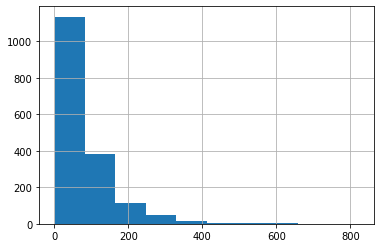

In [9]:
lens.hist();

## Preprocessing

In [10]:
# lowercasing
df['comment'] = df['comment'].str.lower()
df['comment']

0                                          love you sir!!
1       please make videos on..midpoint circle drawing...
2       i bought both of your courses on udemy. you ar...
3       thank you very much, u really got me in the fi...
4       i hope u are ok with everything going on again...
                              ...                        
1704           tanx for de tutorials....vry helpfull...:)
1705                            you could be little fast.
1706    really appreciate your work, it's the best tut...
1707    thanks for this wonderful presentation have ca...
1708            i click the installer and nothing happens
Name: comment, Length: 1709, dtype: object

In [11]:
# checking for NaN values
df.isnull().sum()

comment     0
category    0
dtype: int64

There is no **NaN** value in the dataset.

In [12]:
# checking for duplicate 
df.duplicated().any()

True

Duplicate row is present. Let's remove the duplicate rows.

In [13]:
# # removing duplicate rows
# df = df.drop_duplicates()
# df.duplicated().any()

Duplicated removed succefully.

In [14]:
# Preprocessing

# removing urls
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df['comment'] = df['comment'].replace('\n','', regex=True)

# removing all the punctuations
df['comment'] = df['comment'].str.replace('[^\w\s]',' ')

# removing integers
df['comment'] = df['comment'].replace('\d','', regex=True)

# removing emojis
df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df

,comment,category
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1704,tanx for de tutorials vry helpfull,positive
1705,you could be little fast,imperative
1706,really appreciate your work it s the best tut...,positive
1707,thanks for this wonderful presentation have ca...,interrogative


In [15]:
# removing punctuations except ! and ?
# import string

# def remove_punctuations(text):
    
#     punct = string.punctuation
#     punct = punct.replace('!', '')
#     punct = punct.replace('?', '')
    
#     for punctuation in punct:
#         text = text.replace(punctuation, '')
#     return text

# df["comment"] = df['comment'].apply(remove_punctuations)
# df


In [16]:
# # replacing sequence of "!" with single "!"
# def replace(string, char): 
#     pattern = char + '{2,}'
#     string = re.sub(pattern, char, string)
#     return string 

# char = '!'

# df_ = pd.DataFrame(columns=['comment', 'category'])

# for index, row in df.iterrows():
#     df_ = df_.append({'comment':replace(row['comment'], char), 'category':row['category']}, ignore_index=True)

# df_

In [17]:
# # replacing sequence of "?" with single "?"
# def replace_q(string):
#     char = '?'
#     string = re.sub('[?-?]+', char, string)
#     return string

# df_['comment'] = df_['comment'].apply(replace_q)
# df_

In [18]:
# # correcting the typos
# from autocorrect import Speller

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df['comment'] = df['comment'].apply(typo_corrector)
# df

In [19]:
# # tokenizing
# df_['comment'] = df_.apply(lambda row: nltk.word_tokenize(row['comment']), axis=1)
# df_

In [20]:
# # removing stopwords
# stop = stopwords.words('english')
# negative_words = ['nor','no','not']
# for word in negative_words:
#     stop.remove(word)

# df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df



# Removing stopwords
stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative words
for i in range(len(df)):
    if df['category'][i] == "negative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in for_negative_category])

# For interrogative words
for i in range(len(df)):
    if df['category'][i] == "interrogative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in for_interrogative_category])
        
# For interrogative words
for i in range(len(df)):
    if df['category'][i] == "imperative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in for_imperative_category])
        
# For all other category
for i in range(len(df)):
    if df['category'][i] == "positive" or df['category'][i] == "correction" or df['category'][i] == "other":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in stop])

# df[0] = df[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df


In [21]:
# stemming
stemmer = nltk.stem.SnowballStemmer('english')

df['comment'] = df['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# def stem_text(text):
#     return [stemmer.stem(w) for w in text]

# df_['comment'] = df_['comment'].apply(stem_text)


# # lemmatizing
# lemmatizer = nltk.stem.WordNetLemmatizer()
# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in text]

# df_['comment'] = df_['comment'].apply(lemmatize_text)
# df_

lemmatizer = nltk.stem.WordNetLemmatizer()
df['comment'] = df['comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

df

,comment,category
0,love sir,positive
1,plea make video midpoint circl draw bresenham ...,imperative
2,bought cours udemi are talent teacher keep pro...,interrogative
3,thank much u realli got first video algorithm ...,positive
4,hope u ok everyth go muslim indea,other
...,...,...
1704,tanx de tutori vri helpful,positive
1705,could littl fast,imperative
1706,realli appreci work best tutori found beginn t...,positive
1707,thank wonder present have care follow present ...,interrogative


## Feature Extraction

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=False, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.comment).toarray()

features.shape

(1709, 667)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, df.category, test_size=0.2, random_state=42)

(1709, 2)

## Applying ML Models

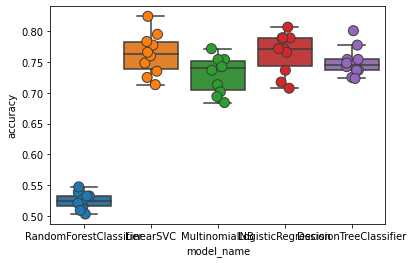

In [40]:
# Applying models
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

labels = df['category']
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [25]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.748975
LinearSVC                 0.763003
LogisticRegression        0.764747
MultinomialNB             0.729646
RandomForestClassifier    0.524297
Name: accuracy, dtype: float64

In [26]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7368421052631579


In [27]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7865497076023392


In [28]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6198830409356725


In [29]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7660818713450293


In [30]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.4269005847953216


In [31]:
# Kernal SVC RBF

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7690058479532164


In [32]:
# Kernal SVC sigmoid

classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7865497076023392


In [33]:
# Kernal SVC poly

classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6871345029239766


In [34]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7953216374269005


In [35]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7339181286549707
